In [ ]:
# ---------------------------
# Block 1 — Mount Drive & copy images to local Colab storage (fast I/O)
# ---------------------------
from google.colab import drive
drive.mount('/content/drive')

# # copy images folder from Drive to Colab local disk (adjust source path if different)
# !cp -r /content/drive/MyDrive/mini_proj_data/images /content/images


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import os

In [24]:
#For Local Machine(Ignore for colab)
df=pd.read_csv(r'C:\Users\ompat\OneDrive\Desktop\mini_proj_data\processed_data.csv')
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,label_id,is_malignant,clean_path,variant
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,2,0,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,clean
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,2,0,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,clean
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,2,0,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,clean
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,2,0,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,clean
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,2,0,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,clean
...,...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,0,1,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,clean
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,0,1,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,clean
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,0,1,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,clean
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,0,1,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,clean


In [25]:
df = pd.read_csv('/content/drive/MyDrive/mini_proj_data/processed_data.csv')
df

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/mini_proj_data/processed_data.csv'

In [26]:
df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'image_path', 'label_id', 'is_malignant', 'clean_path', 'variant'],
      dtype='object')

In [27]:
# ---------------------------
# Block 2 — Load CSV, prepare metadata, labels and image paths; create train/val/test splits
# ---------------------------


# Keep only useful cols
# Keep lesion_id to avoid leakage
y = df['label_id'].values
df = df[['lesion_id','image_path','clean_path','age','sex','localization',
         'dx_type','is_malignant','variant']].copy()

# --- Handle missing values safely ---
df['age'] = pd.to_numeric(df['age'], errors='coerce')   # force non-numeric → NaN
df['age'] = df['age'].fillna(df['age'].median())        # fill NaN with median

# Clean up sex values (some datasets have 'unknown' or nan)
df['sex'] = df['sex'].str.lower().replace({'nan': np.nan, 'unknown': np.nan, '': np.nan})
df['sex'] = df['sex'].map({'male':0,'female':1})
df['sex'] = df['sex'].fillna(-1).astype('float32')      # -1 = unknown, keeps row

# Drop rows where image path is missing
df = df.dropna(subset=['clean_path','is_malignant'])

# One-hot encode categorical vars (fills missing with "unknown")
for col in ['localization','dx_type']:
    df[col] = df[col].fillna('unknown')
df = pd.get_dummies(df, columns=['localization','dx_type','variant'], drop_first=False)

# Scale age safely/
scaler = StandardScaler()
df['age_scaled'] = scaler.fit_transform(df[['age']]).astype('float32')

In [28]:
df

,lesion_id,image_path,clean_path,age,sex,is_malignant,localization_abdomen,localization_acral,localization_back,localization_chest,...,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity,dx_type_confocal,dx_type_consensus,dx_type_follow_up,dx_type_histo,variant_clean,age_scaled
0,HAM_0000118,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,80.0,0.0,0,False,False,False,False,...,True,False,False,False,False,False,False,True,True,1.663522
1,HAM_0000118,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,80.0,0.0,0,False,False,False,False,...,True,False,False,False,False,False,False,True,True,1.663522
2,HAM_0002730,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,80.0,0.0,0,False,False,False,False,...,True,False,False,False,False,False,False,True,True,1.663522
3,HAM_0002730,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,80.0,0.0,0,False,False,False,False,...,True,False,False,False,False,False,False,True,True,1.663522
4,HAM_0001466,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,75.0,0.0,0,False,False,False,False,...,False,False,False,False,False,False,False,True,True,1.368014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,40.0,0.0,1,True,False,False,False,...,False,False,False,False,False,False,False,True,True,-0.700545
10011,HAM_0002867,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,40.0,0.0,1,True,False,False,False,...,False,False,False,False,False,False,False,True,True,-0.700545
10012,HAM_0002867,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,40.0,0.0,1,True,False,False,False,...,False,False,False,False,False,False,False,True,True,-0.700545
10013,HAM_0000239,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,80.0,0.0,1,False,False,False,False,...,False,False,False,False,False,False,False,True,True,1.663522


In [29]:
y


array([2, 2, 2, ..., 0, 0, 4], shape=(10015,))

In [30]:
# Metadata features
feature_cols = ['age_scaled','sex'] + [c for c in df.columns if c.startswith('localization_')
                                        or c.startswith('dx_type_')
                                        or c.startswith('variant_')]
X_meta = df[feature_cols].values.astype('float32')

X_meta


array([[ 1.6635225 ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  1.        ],
       [ 1.6635225 ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  1.        ],
       [ 1.6635225 ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  1.        ],
       ...,
       [-0.70054543,  0.        ,  1.        , ...,  0.        ,
         1.        ,  1.        ],
       [ 1.6635225 ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  1.        ],
       [ 1.0725055 ,  1.        ,  0.        , ...,  0.        ,
         1.        ,  1.        ]], shape=(10015, 22), dtype=float32)

In [31]:
X_meta.shape

(10015, 22)

In [32]:
X = df['clean_path']   # paths to images



In [14]:
from sklearn.model_selection import train_test_split

# Train + validation and test split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

# Train and validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1, stratify=y_train_val, random_state=42
)


In [33]:
import cv2
import numpy as np

def load_and_preprocess_image(path, target_size=(224,224)):
    img = cv2.imread(path)                      # read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    img = cv2.resize(img, target_size)
    img = img / 255.0                           # normalize to [0,1]
    return img.astype('float32')

# --- Load datasets ---
# X_train_images = np.array([load_and_preprocess_image(p) for p in X_train])
# X_val_images   = np.array([load_and_preprocess_image(p) for p in X_val])
# X_test_images  = np.array([load_and_preprocess_image(p) for p in X_test])
X_images=np.array([load_and_preprocess_image(p) for p in X])

# --- Standardization step (per-channel) ---
mean = np.mean(X_images, axis=(0,1,2), keepdims=True)
std  = np.std(X_images, axis=(0,1,2), keepdims=True)

X_images = (X_images - mean) / (std + 1e-7)
# X_val_images   = (X_val_images   - mean) / (std + 1e-7)
# X_test_images  = (X_test_images  - mean) / (std + 1e-7)


In [34]:
X_images

array([[[[ 3.4443824 ,  2.6502833 ,  3.5302312 ],
         [ 3.659004  ,  2.8649046 ,  3.7448525 ],
         [ 3.6804662 ,  2.8863668 ,  3.809239  ],
         ...,
         [ 3.8736255 ,  2.9936776 ,  3.2941475 ],
         [ 3.9165497 ,  3.0366018 ,  3.4229205 ],
         [ 4.088247  ,  3.208299  ,  3.5946176 ]],

        [[ 3.4658446 ,  2.6502833 ,  3.5302312 ],
         [ 3.7233903 ,  2.929291  ,  3.809239  ],
         [ 3.8521633 ,  3.058064  ,  3.980936  ],
         ...,
         [ 3.8521633 ,  2.9722154 ,  3.2726853 ],
         [ 4.152633  ,  3.2726853 ,  3.6160798 ],
         [ 4.0453224 ,  3.1653748 ,  3.508769  ]],

        [[ 3.5516932 ,  2.6717453 ,  3.5302312 ],
         [ 3.6375418 ,  2.8219805 ,  3.659004  ],
         [ 3.7019284 ,  2.8863668 ,  3.7663147 ],
         ...,
         [ 3.8521633 ,  2.9507532 ,  3.208299  ],
         [ 4.109709  ,  3.208299  ,  3.4658446 ],
         [ 3.959474  ,  3.058064  ,  3.3585339 ]],

        ...,

        [[ 2.2425025 ,  1.5342516 ,  2

In [35]:
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout, Input
import tensorflow as tf

# ---------------- CNN1 ----------------
def build_cnn1(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3,3), activation='relu', padding="same",
               kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(64, (3,3), activation='relu', padding="same",
               kernel_regularizer=regularizers.l2(1e-4))(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(128, (3,3), activation='relu', padding="same",
               kernel_regularizer=regularizers.l2(1e-4))(x)
    x = MaxPooling2D((2,2))(x)

    x = Flatten()(x)
    x = Dropout(0.5)(x)   # still useful to avoid overfitting
    return Model(inputs, x, name="CNN1")

# ---------------- CNN2 ----------------
def build_cnn2(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv2D(256, (7,7), activation='relu', padding="same",
               kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = AveragePooling2D((2,2))(x)

    x = Conv2D(128, (5,5), activation='relu', padding="same",
               kernel_regularizer=regularizers.l2(1e-4))(x)
    x = AveragePooling2D((2,2))(x)

    x = Conv2D(96, (3,3), activation='relu', padding="same",
               kernel_regularizer=regularizers.l2(1e-4))(x)
    x = AveragePooling2D((2,2))(x)

    x = Flatten()(x)
    x = Dropout(0.5)(x)
    return Model(inputs, x, name="CNN2")


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
# datagen.fit(X_train_images)


In [37]:
input_shape = (224, 224, 3)
CNN1 = build_cnn1(input_shape)
CNN2 = build_cnn2(input_shape)
print("---- CNN1 Summary ----")
CNN1.summary()

print("\n---- CNN2 Summary ----")
CNN2.summary()
# Use augmented data for feature extraction
# train_generator = datagen.flow(X_train_images, y_train, batch_size=32, shuffle=False)

---- CNN1 Summary ----


Model: "CNN1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100352)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,248 (364.25 KB)

 Trainable params: 93,248 (364.25 KB)

 Non-trainable params: 0 (0.00 B)


---- CNN2 Summary ----


Model: "CNN2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 224, 224, 256)  │        37,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 112, 112, 256)  │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 112, 112, 128)  │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 56, 56, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 56, 56, 96)     │       110,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (None, 28, 28, 96)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 75264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75264)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 967,904 (3.69 MB)

 Trainable params: 967,904 (3.69 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [39]:
features_cnn1 = CNN1.predict(X_images, verbose=1)
features_cnn2 = CNN2.predict(X_images, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 120s 374ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1191s 4s/step


In [ ]:
# # Validation generator (no augmentation)
# val_datagen = ImageDataGenerator()

# val_generator = val_datagen.flow(
#     X_val_images, y_val,
#     batch_size=32,
#     shuffle=False
# # 

# # Now extract features
# features_cnn1_val = CNN1.predict(val_generator, verbose=1)
# features_cnn2_val = CNN2.predict(val_generator, verbose=1)

c:\Users\ompat\OneDrive\Desktop\Skin-Cancer-Classification\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step


In [ ]:
# # ---------------- Dimensionality Reduction ----------------
# pca = PCA(n_components=50)
# features_pca = pca.fit_transform(features_cnn1)
# features_pca_val = pca.transform(features_cnn1_val)

# fa = FactorAnalysis(n_components=50)
# features_fa = fa.fit_transform(features_cnn2)
# features_fa_val = fa.transform(features_cnn2_val)

NameError: name 'features_cnn1' is not defined

In [40]:
pca = PCA(n_components=50)
all_features = np.concatenate([features_cnn1, features_cnn2], axis=1)
features_pca = pca.fit_transform(all_features)

# later you can split back if needed


In [ ]:
# # Merge
# merged_features = np.concatenate([features_pca, features_fa], axis=1)
# merged_features_val = np.concatenate([features_pca_val, features_fa_val], axis=1)

In [64]:
from sklearn.model_selection import train_test_split

# Suppose these are ready
# merged_features.shape -> (N_samples, N_features)
# labels.shape           -> (N_samples,) or one-hot (N_samples, 7)

# Step 1: Train + temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    features_pca, y, test_size=0.3, random_state=42, stratify=y
)

# Step 2: Validation + Test (split from temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


Train: (7010, 50) (7010,)
Val:   (1502, 50) (1502,)
Test:  (1503, 50) (1503,)


In [ ]:
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# # Get unique class labels
# class_labels = np.unique(y_train)

# # Compute weights
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=class_labels,
#     y=y_train
# )

# # Convert to dictionary {class_label: weight}
# class_weights = dict(zip(class_labels, class_weights))

# print("Class Weights:", class_weights)


Class Weights: {np.int64(0): np.float64(4.37305053025577), np.int64(1): np.float64(2.7817460317460316), np.int64(2): np.float64(1.3022478172023035), np.int64(3): np.float64(12.36331569664903), np.int64(4): np.float64(1.285530900421786), np.int64(5): np.float64(0.21338772031292808), np.int64(6): np.float64(10.115440115440116)}


In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
# ---------------- Classifier ----------------
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
# Early stopping callback



c:\Users\ompat\OneDrive\Desktop\Skin-Cancer-Classification\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │        13,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,663 (213.53 KB)

 Trainable params: 54,663 (213.53 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
history = model.fit(
    X_train, y_train,   # <-- use your numpy labels directly
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=64,
    callbacks=[early_stop], 
       # <- stops when val_acc stops improving
    verbose=1
)


Epoch 1/80
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9449 - loss: 0.1502 - val_accuracy: 0.7330 - val_loss: 1.1991
Epoch 2/80
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9468 - loss: 0.1487 - val_accuracy: 0.7330 - val_loss: 1.3022
Epoch 3/80
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9496 - loss: 0.1449 - val_accuracy: 0.7290 - val_loss: 1.3519
Epoch 4/80
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9498 - loss: 0.1411 - val_accuracy: 0.7277 - val_loss: 1.3122
Epoch 5/80
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9506 - loss: 0.1447 - val_accuracy: 0.7423 - val_loss: 1.3052


In [73]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7252 - loss: 1.2663
✅ Test Accuracy: 0.7252
✅ Test Loss: 1.2663


In [74]:
y_pred_probs = model.predict(X_test)             # probabilities (N, 7)
y_pred = np.argmax(y_pred_probs, axis=1)         # predicted labels (N,)


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [75]:
from sklearn.metrics import classification_report

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, digits=4))



📊 Classification Report:
              precision    recall  f1-score   support

           0     0.3556    0.3265    0.3404        49
           1     0.4125    0.4286    0.4204        77
           2     0.4474    0.4121    0.4290       165
           3     0.2727    0.1765    0.2143        17
           4     0.3972    0.3353    0.3636       167
           5     0.8549    0.9016    0.8776      1006
           6     0.5385    0.3182    0.4000        22

    accuracy                         0.7252      1503
   macro avg     0.4684    0.4141    0.4351      1503
weighted avg     0.7091    0.7252    0.7158      1503



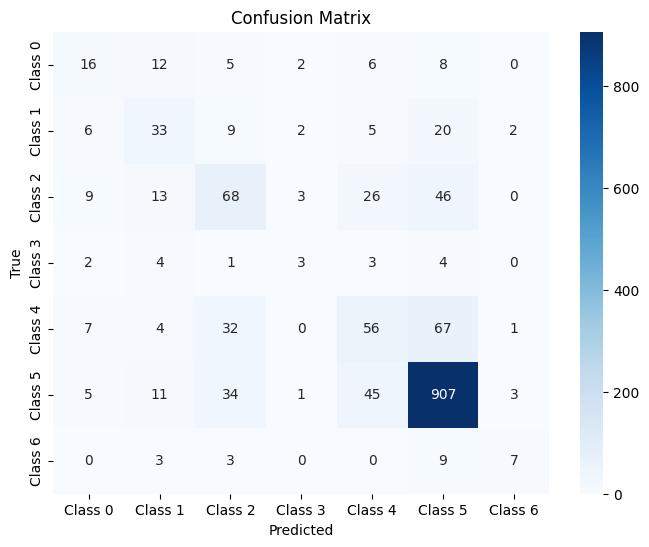

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"Class {i}" for i in range(7)],
            yticklabels=[f"Class {i}" for i in range(7)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [77]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize test labels (one-hot for ROC)
y_test_bin = label_binarize(y_test, classes=np.arange(7))

# ROC-AUC (macro average)
roc_auc = roc_auc_score(y_test_bin, y_pred_probs, multi_class="ovr")
print(f" ROC-AUC (macro): {roc_auc:.4f}")


 ROC-AUC (macro): 0.8812


In [1]:
import pickle

# Load pickle file
with open("merged_features.pkl", "rb") as f:
    merged_features = pickle.load(f)

with open("merged_features_val.pkl", "rb") as f:
    merged_features_val = pickle.load(f)



In [2]:
from tensorflow.keras.models import load_model

# Load keras model
classifier_model = load_model("classifier_model.h5")

In [20]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Step 1: Extract test features ---
features_cnn1_test = CNN1.predict(X_test_images, verbose=1)
features_cnn2_test = CNN2.predict(X_test_images, verbose=1)


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step


In [21]:
# --- Step 2: Apply trained PCA & FA (do NOT fit again, only transform) ---
features_pca_test = pca.transform(features_cnn1_test)
features_fa_test  = fa.transform(features_cnn2_test)


NameError: name 'pca' is not defined